# 

The packages necessary for the simulation.

In [1]:
using PyPlot, JutulDarcyRules, LinearAlgebra, JLD2, Polynomials

In [2]:
# For the first time, run this cell twice to download data and then load the data
if ~isfile("BGCompass_tti.jld2")
    run(`wget -q -O BGCompass_tti.jld2 "https://www.dropbox.com/scl/fi/gs0eh2ldv9til0r7cg27n/BGCompass_tti.jld2?rlkey=bs2sil1ljiztl5bytlqghcm82&st=s5dnrjoh&dl=1"`)
else
    JLD2.@load "BGCompass_tti.jld2" m d
end

2-element Vector{Symbol}:
 :m
 :d

In [3]:
# Some necessary type conversions and defining size of velocity
v = Float64.(sqrt.(1f0./m));
d = Float64.(d);
n = size(v)

(325, 171)

In [4]:
# You do not need to modify this code block, which defines the helper function
# A basic function to find water bottom layer index values 
function find_water_bottom(m::AbstractArray{avDT,2};eps = 1e-4) where {avDT}
    # return the indices of the water bottom of a seismic image
    n = size(m)
    idx = zeros(Integer, n[1])
    for j=1:n[1]
        k=1
        while true
            if abs(m[j,k]) > eps
                idx[j] = k
                break
            end
            k += 1
        end
    end
    return idx
end

# Changing velocity model to permeability
function VtoK(v::Matrix{T}, d::Tuple{T, T}; α::T=T(10)) where T

    n = size(v)
    idx_wb = find_water_bottom(v.-minimum(v))
    idx_ucfmt = find_water_bottom((v.-T(3.5)).*(v.>T(3.5)))
    Kh = zeros(T, n)
    capgrid = Int(round(T(50)/d[2]))
    for i = 1:n[1]
        Kh[i,1:idx_wb[i]-1] .= T(1e-10)  # water layer
        Kh[i,idx_wb[i]:idx_ucfmt[i]-capgrid-1] .= α*exp.(v[i,idx_wb[i]:idx_ucfmt[i]-capgrid-1])
        Kh[i,idx_ucfmt[i]-capgrid:idx_ucfmt[i]-1] .= T(1e-3)
        Kh[i,idx_ucfmt[i]:end] .= α*exp.(v[i,idx_ucfmt[i]:end]) .- T(320)
    end
    return Kh
end
Kh = VtoK(v, d);

# This part is used to create porosity 
idx_wb = find_water_bottom(v.-minimum(v));
idx_ucfmt = find_water_bottom((v.-3.5).*(v.>3.5))
phi = zeros(Float64,n)
for i = 1:n[1]
    for j = 1:n[2]
        p = Polynomial([-0.0314^2*Kh[i,j],2*0.0314^2*Kh[i,j],-0.0314^2*Kh[i,j],1.527^2]) 
        phi[i,j] = minimum(real(roots(p)[findall(real(roots(p)).== roots(p))]))
    end
    for j = idx_ucfmt[i]:idx_ucfmt[i]+8
        phi[i,idx_ucfmt[i]:idx_ucfmt[i]+8] = Float64.(range(0.056,stop=0.1,length=9))
    end
end

In [5]:
# We will use a subset of the permeability model to make simulation faster.
Kh = Kh[151:240, :]
K = Float64.(Kh * md);
n = (size(K,1), 1, size(K,2))
d = (d[1], 50.0, d[2])
phi = phi[151:240, :]
phi_m = convert(Array{Float64,1},vec(phi));
ϕ = phi

# We set boundary values of porosity to 1e8. This will prevent over-pressurization.
ϕ[1,:] .= 1e8
ϕ[:,1] .= 1e8
ϕ[end,:] .= 1e8
ϕ[:,end] .= 1e8
ϕ = convert(Array{Float64,1},vec(ϕ));

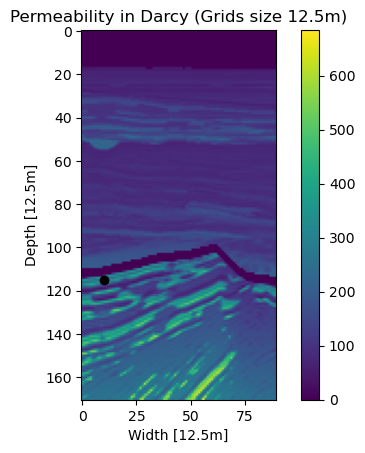

PyObject <matplotlib.collections.PathCollection object at 0x2aabfd77e300>

In [6]:
# Plot permeability map 
i=10
imshow(Kh'); colorbar(); xlabel("Width [12.5m]"); ylabel("Depth [12.5m]"); title("Permeability in Darcy (Grids size 12.5m)")
scatter(i,idx_ucfmt[i+150], c= "k")

In [7]:
# Create the model
model = jutulModel(n, d, ϕ, K1to3(K))

jutulModel{3, Float64}((90, 1, 171), (12.5, 50.0, 12.5), [1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8  …  1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8], [9.86923266716013e-26 9.86923266716013e-26 … 2.436621876880626e-13 2.351440606894287e-13; 9.86923266716013e-26 9.86923266716013e-26 … 2.436621876880626e-13 2.351440606894287e-13; 9.86923266716013e-26 9.86923266716013e-26 … 2.436621876880626e-13 2.351440606894287e-13], 0.0)

In [8]:
# Simulation
tstep = 500 * ones(2) # This corresponds to 1000 days. 500 is dt and 2 is number of time steps. 

# Injection & production (source & sink) location
inj_loc = (5, 1, n[end]-10) .* d

# Injectivity is in m^3 per sec
irate = 8e-1
q1 = jutulForce(irate, [inj_loc])

# Set up modeling operator
S = jutulModeling(model, tstep)
Trans = KtoTrans(CartesianMesh(model), K1to3(K))

30519-element Vector{Float64}:
 4.934616333580065e-24
 4.934616333580065e-24
 4.934616333580065e-24
 4.934616333580065e-24
 4.934616333580065e-24
 4.934616333580065e-24
 4.934616333580065e-24
 4.934616333580065e-24
 4.934616333580065e-24
 4.934616333580065e-24
 4.934616333580065e-24
 4.934616333580065e-24
 4.934616333580065e-24
 ⋮
 1.1972388010575527e-11
 1.108071705063072e-11
 1.1610390486326076e-11
 1.2174659406879921e-11
 1.2312219438636536e-11
 1.1962770008765545e-11
 1.127970625447385e-11
 1.1955957535180821e-11
 1.2019857324186095e-11
 1.203614465756906e-11
 1.2151810830393084e-11
 1.1941790969387475e-11

In [9]:
# First Step
@time state = S(log.(Trans), q1; info_level=1)

pressure = reshape(Pressure(state.states[end]), (n[1], n[end]))'
point_pressure = pressure[idx_ucfmt[20+150],20]
println("Did you satisfy pressure criteria: ", (point_pressure > 1.3e7 && (point_pressure < 1.5e7)))
println("Pressure below seal for a specific point: ", point_pressure)
@assert(point_pressure > 1.3e7 && (point_pressure < 1.5e7))

Jutul: Simulating 142 weeks, 6 days as 2 report steps
Step 1/2: Solving start to 71 weeks, 3 days, Δt = 71 weeks, 3 days 
Step 2/2: Solving 71 weeks, 3 days to 142 weeks, 6 days, Δt = 71 weeks, 3 days 
Simulation complete: Completed 2 timesteps in 4 minutes, 1 second, 503 milliseconds and 152 iterations.
╭────────────────┬──────────┬──────────────┬──────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │ Time per │    Total │
│                │  2 steps │ 27 ministeps │        s │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┼──────────┤
│ Newton         │     76.0 │      5.62963 │   1.5888 │  152 (0) │
│ Linearization  │     89.5 │      6.62963 │   1.3492 │  179 (0) │
│ Linear solver  │    172.0 │      12.7407 │   0.7020 │  344 (0) │
╰────────────────┴──────────┴──────────────┴──────────┴──────────╯
╭────────────────┬────────┬────────────┬──────────╮
│ Timing type    │   Each │   Relative │    Total │
│                │      s │ Percentage │        s │
├─

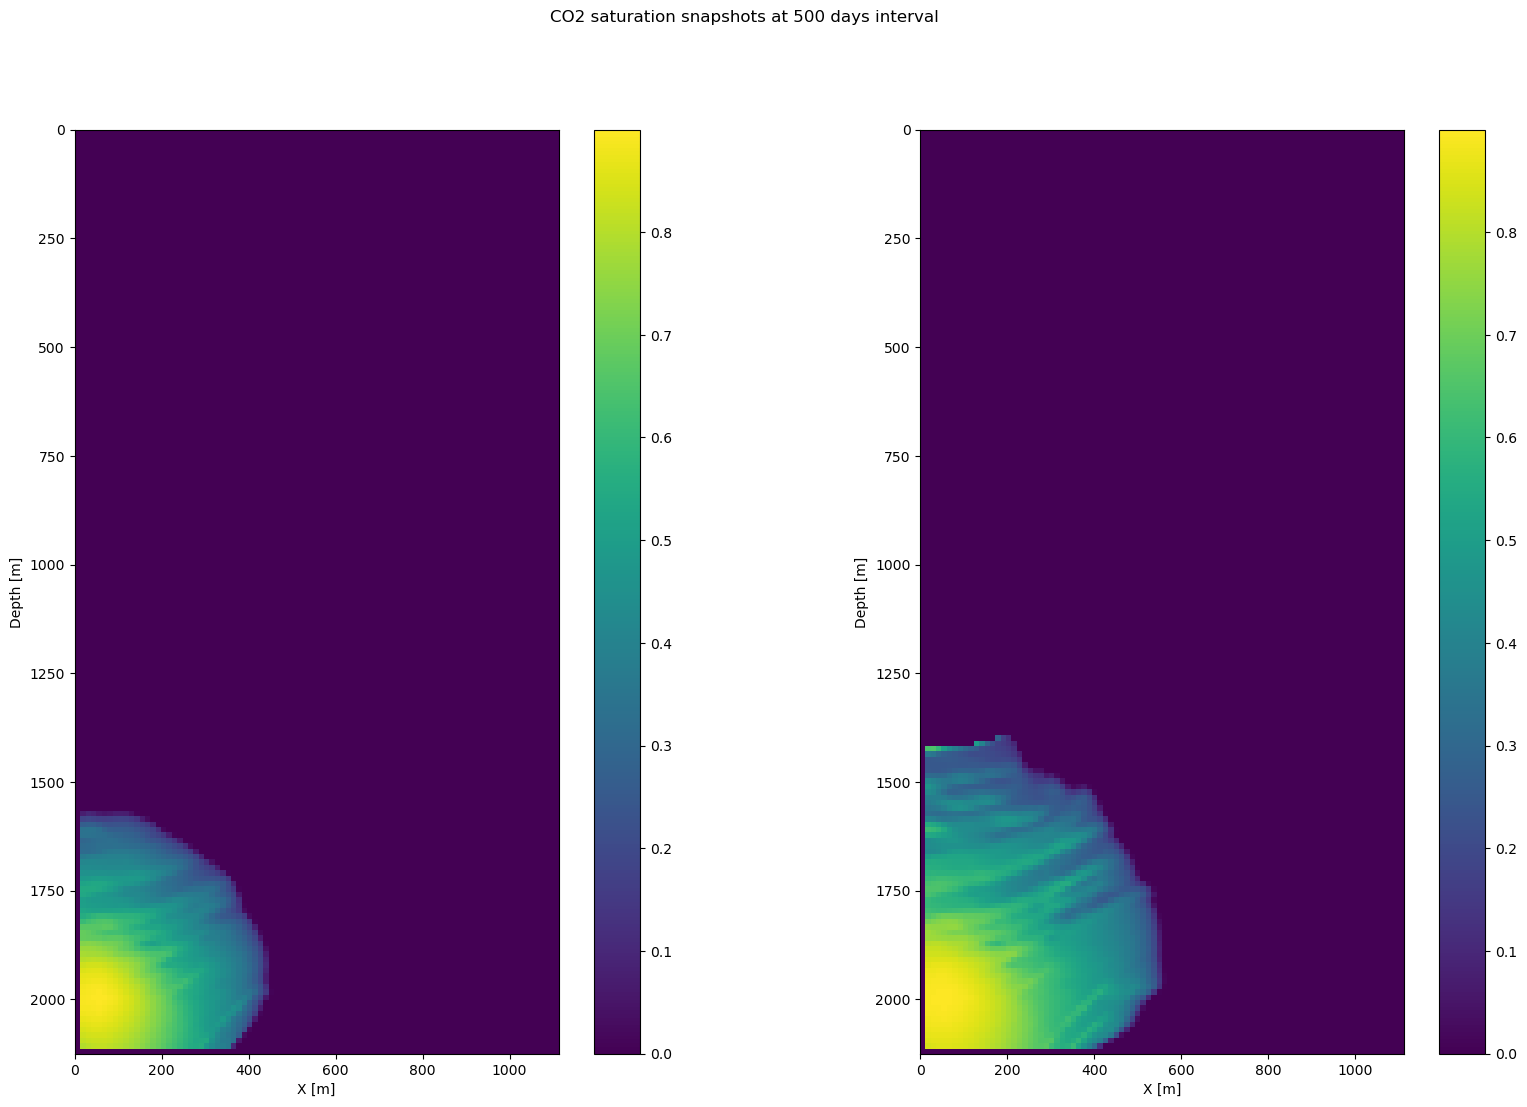

PyObject Text(0.5, 0.98, 'CO2 saturation snapshots at 500 days interval')

In [10]:
# Plot first-step saturation results
figure(figsize=(20,12));
for i = 1:2
    subplot(1,2,i)
    imshow(reshape(Saturations(state.states[i]), n[1], n[end])', extent=(0,(n[1]-1)*d[1],(n[3]-1)*d[3],0); vmin=0, vmax=maximum(Saturations(state.states[end])))
    xlabel("X [m]");ylabel("Depth [m]");
    colorbar()
end
suptitle("CO2 saturation snapshots at 500 days interval")

In [11]:
# Second Step
# Keep injection rate as high as possible but also consider the pressure criterion
irate = 9e-1
q2 = jutulForce(irate, [inj_loc])

stateend = state.states[end]
@time state = S(log.(Trans), q2; state0=stateend)
pressure = reshape(Pressure(state.states[end]), (n[1], n[end]))'
point_pressure = pressure[idx_ucfmt[20+150],20]
println("Did you satisfy pressure criteria: ", (point_pressure > 1.3e7 && (point_pressure < 1.5e7)))
println("Pressure below seal for a specific point: ", point_pressure)
@assert(point_pressure > 1.3e7 && (point_pressure < 1.5e7))

╭────────────────┬──────────┬──────────────┬──────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │ Time per │    Total │
│                │  2 steps │ 27 ministeps │       ms │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┼──────────┤
│ Newton         │     92.0 │      6.81481 │ 346.1495 │ 184 (15) │
│ Linearization  │    105.5 │      7.81481 │ 301.8555 │ 211 (16) │
│ Linear solver  │    297.5 │       22.037 │ 107.0445 │ 595 (45) │
╰────────────────┴──────────┴──────────────┴──────────┴──────────╯
╭────────────────┬──────────┬────────────┬─────────╮
│ Timing type    │     Each │   Relative │   Total │
│                │       ms │ Percentage │       s │
├────────────────┼──────────┼────────────┼─────────┤
│ Properties     │   9.2746 │     2.68 % │  1.7065 │
│ Equations      │  38.6487 │    12.80 % │  8.1549 │
│ Assembly       │   7.0589 │     2.34 % │  1.4894 │
│ Linear solve   │ 215.7550 │    62.33 % │ 39.6989 │
│ Preconditioner │  21.3098 │     6.16 %

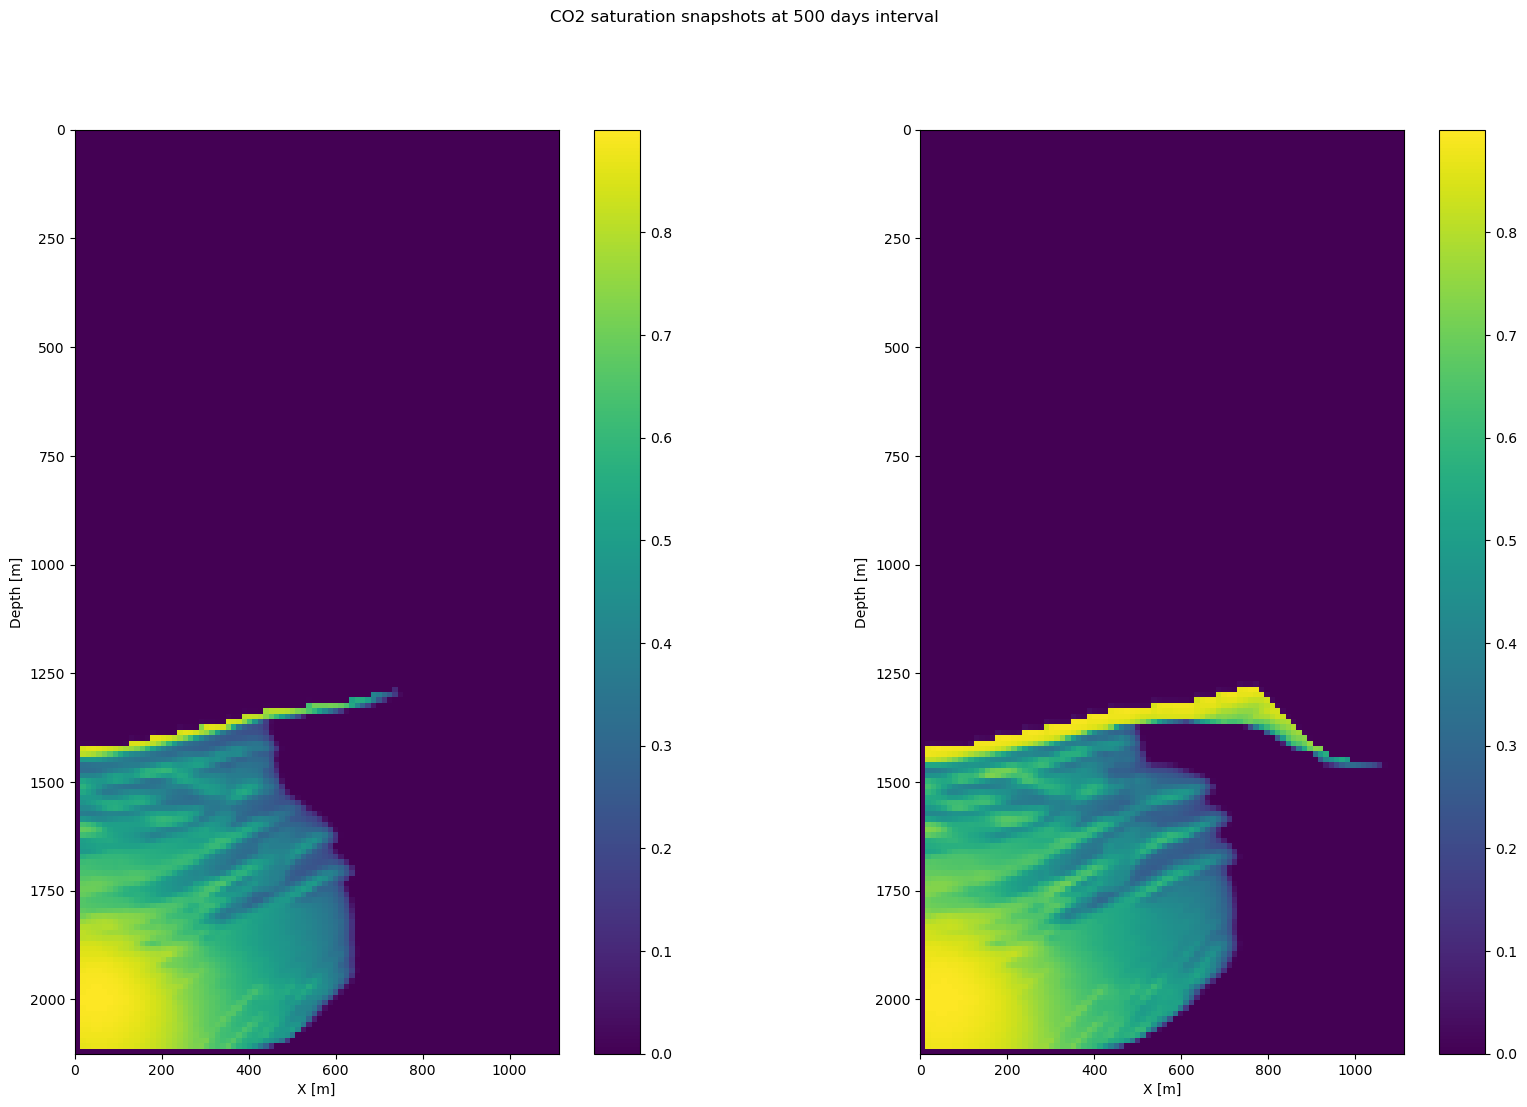

PyObject Text(0.5, 0.98, 'CO2 saturation snapshots at 500 days interval')

In [12]:
# Plot second-step saturation results
figure(figsize=(20,12));
for i = 1:2
    subplot(1,2,i)
    imshow(reshape(Saturations(state.states[i]), n[1], n[end])', extent=(0,(n[1]-1)*d[1],(n[3]-1)*d[3],0); vmin=0, vmax=maximum(Saturations(state.states[end])))
    xlabel("X [m]");ylabel("Depth [m]");
    colorbar()
end
suptitle("CO2 saturation snapshots at 500 days interval")

In [13]:
# Third Step
# Keep injection rate as high as possible but also consider the pressure criterion
irate = 50e-2
q3 = jutulForce(irate, [inj_loc])

stateend = state.states[end]
@time state = S(log.(Trans), q3;state0=stateend)
pressure = reshape(Pressure(state.states[end]), (n[1], n[end]))'
point_pressure = pressure[idx_ucfmt[20+150],20]
println("Did you satisfy pressure criteria: ", (point_pressure > 1.3e7 && (point_pressure < 1.5e7)))
println("Pressure below seal for a specific point: ", point_pressure)
@assert(point_pressure > 1.3e7 && (point_pressure < 1.5e7))

╭────────────────┬──────────┬──────────────┬──────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │ Time per │    Total │
│                │  2 steps │ 22 ministeps │       ms │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┼──────────┤
│ Newton         │     63.0 │      5.72727 │ 356.4619 │ 126 (15) │
│ Linearization  │     74.0 │      6.72727 │ 303.4743 │ 148 (16) │
│ Linear solver  │    241.5 │      21.9545 │  92.9901 │ 483 (75) │
╰────────────────┴──────────┴──────────────┴──────────┴──────────╯
╭────────────────┬──────────┬────────────┬─────────╮
│ Timing type    │     Each │   Relative │   Total │
│                │       ms │ Percentage │       s │
├────────────────┼──────────┼────────────┼─────────┤
│ Properties     │   9.6415 │     2.70 % │  1.2148 │
│ Equations      │  37.3834 │    12.32 % │  5.5327 │
│ Assembly       │   7.2643 │     2.39 % │  1.0751 │
│ Linear solve   │ 252.9722 │    70.97 % │ 31.8745 │
│ Preconditioner │  22.9132 │     6.43 %

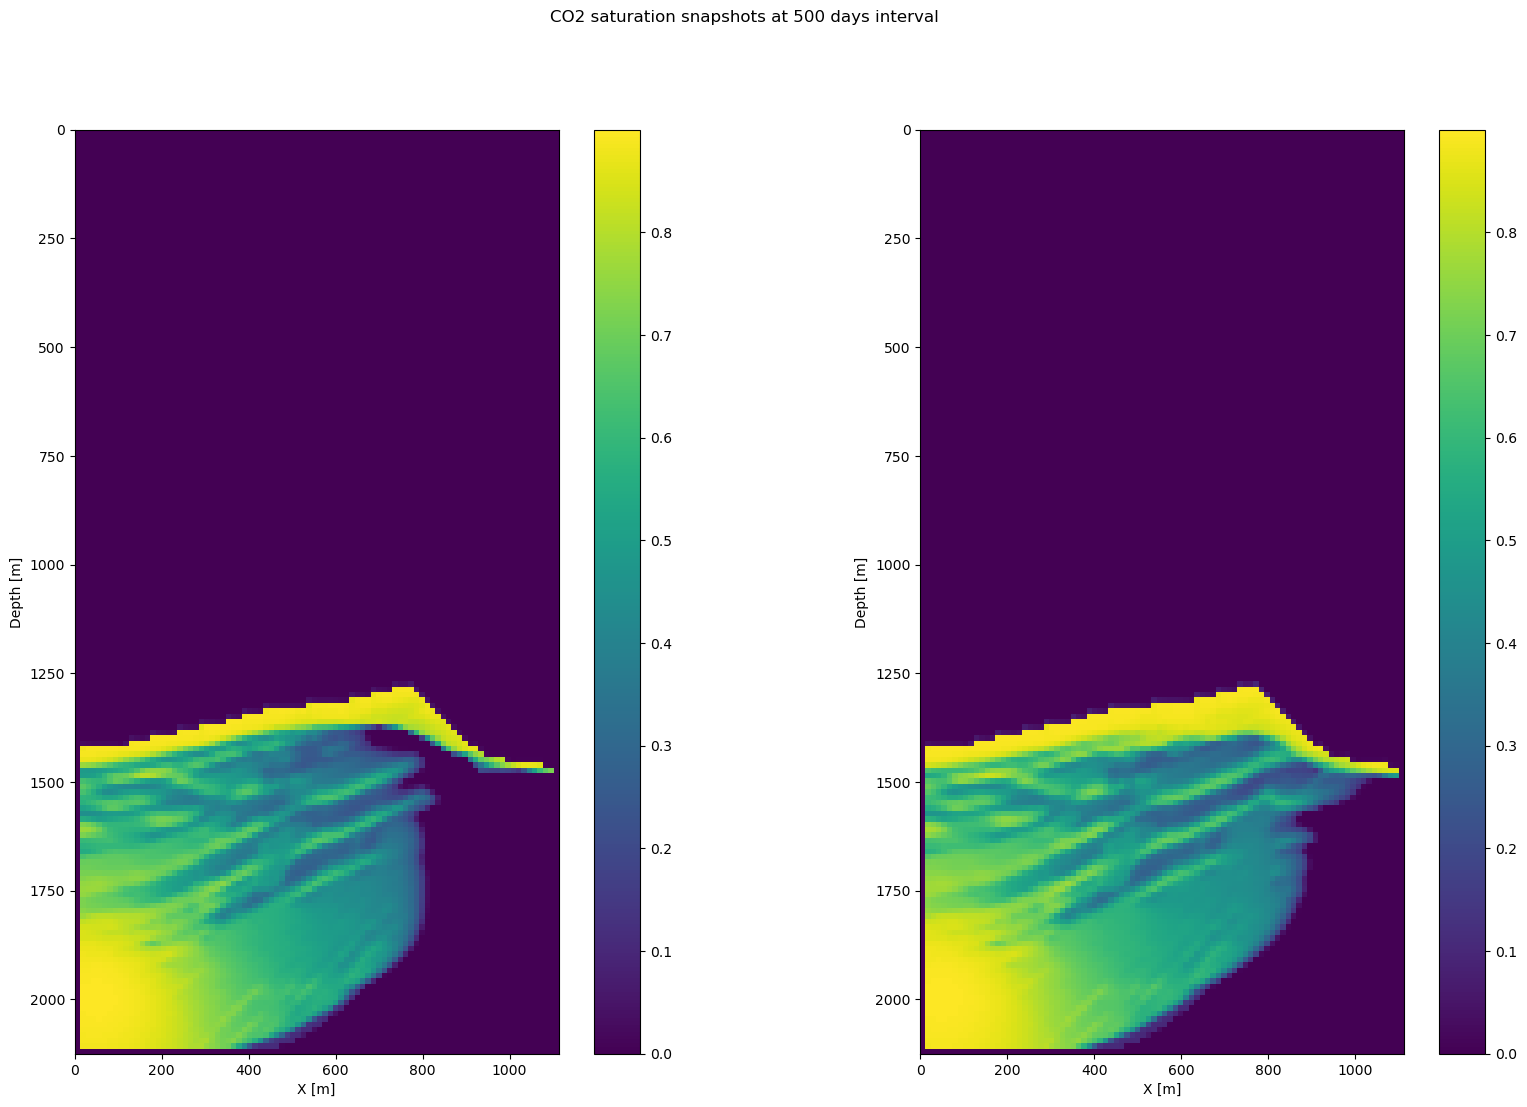

PyObject Text(0.5, 0.98, 'CO2 saturation snapshots at 500 days interval')

In [14]:
# Plot third-step saturation results
figure(figsize=(20,12));
for i = 1:2
    subplot(1,2,i)
    imshow(reshape(Saturations(state.states[i]), n[1], n[end])', extent=(0,(n[1]-1)*d[1],(n[3]-1)*d[3],0); vmin=0, vmax=maximum(Saturations(state.states[end])))
    xlabel("X [m]");ylabel("Depth [m]");
    colorbar()
end
suptitle("CO2 saturation snapshots at 500 days interval")

In [15]:
# Fourth Step
# Keep injection rate as high as possible but also consider the pressure criterion
irate = 50e-2
q4 = jutulForce(irate, [inj_loc])

stateend = state.states[end]
@time state = S(log.(Trans), q4; state0=stateend)
pressure = reshape(Pressure(state.states[end]), (n[1], n[end]))'
point_pressure = pressure[idx_ucfmt[20+150],20]
println("Did you satisfy pressure criteria: ", (point_pressure > 1.3e7 && (point_pressure < 1.5e7)))
println("Pressure below seal for a specific point: ", point_pressure)
@assert(point_pressure > 1.3e7 && (point_pressure < 1.5e7))

╭────────────────┬──────────┬──────────────┬──────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │ Time per │    Total │
│                │  2 steps │ 15 ministeps │       ms │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┼──────────┤
│ Newton         │     37.0 │      4.93333 │ 331.9071 │   74 (0) │
│ Linearization  │     44.5 │      5.93333 │ 275.9677 │   89 (0) │
│ Linear solver  │    126.0 │         16.8 │  97.4648 │  252 (0) │
╰────────────────┴──────────┴──────────────┴──────────┴──────────╯
╭────────────────┬──────────┬────────────┬─────────╮
│ Timing type    │     Each │   Relative │   Total │
│                │       ms │ Percentage │       s │
├────────────────┼──────────┼────────────┼─────────┤
│ Properties     │   9.3959 │     2.83 % │  0.6953 │
│ Equations      │  38.8861 │    14.09 % │  3.4609 │
│ Assembly       │   6.9455 │     2.52 % │  0.6182 │
│ Linear solve   │ 223.7390 │    67.41 % │ 16.5567 │
│ Preconditioner │  25.1439 │     7.58 %

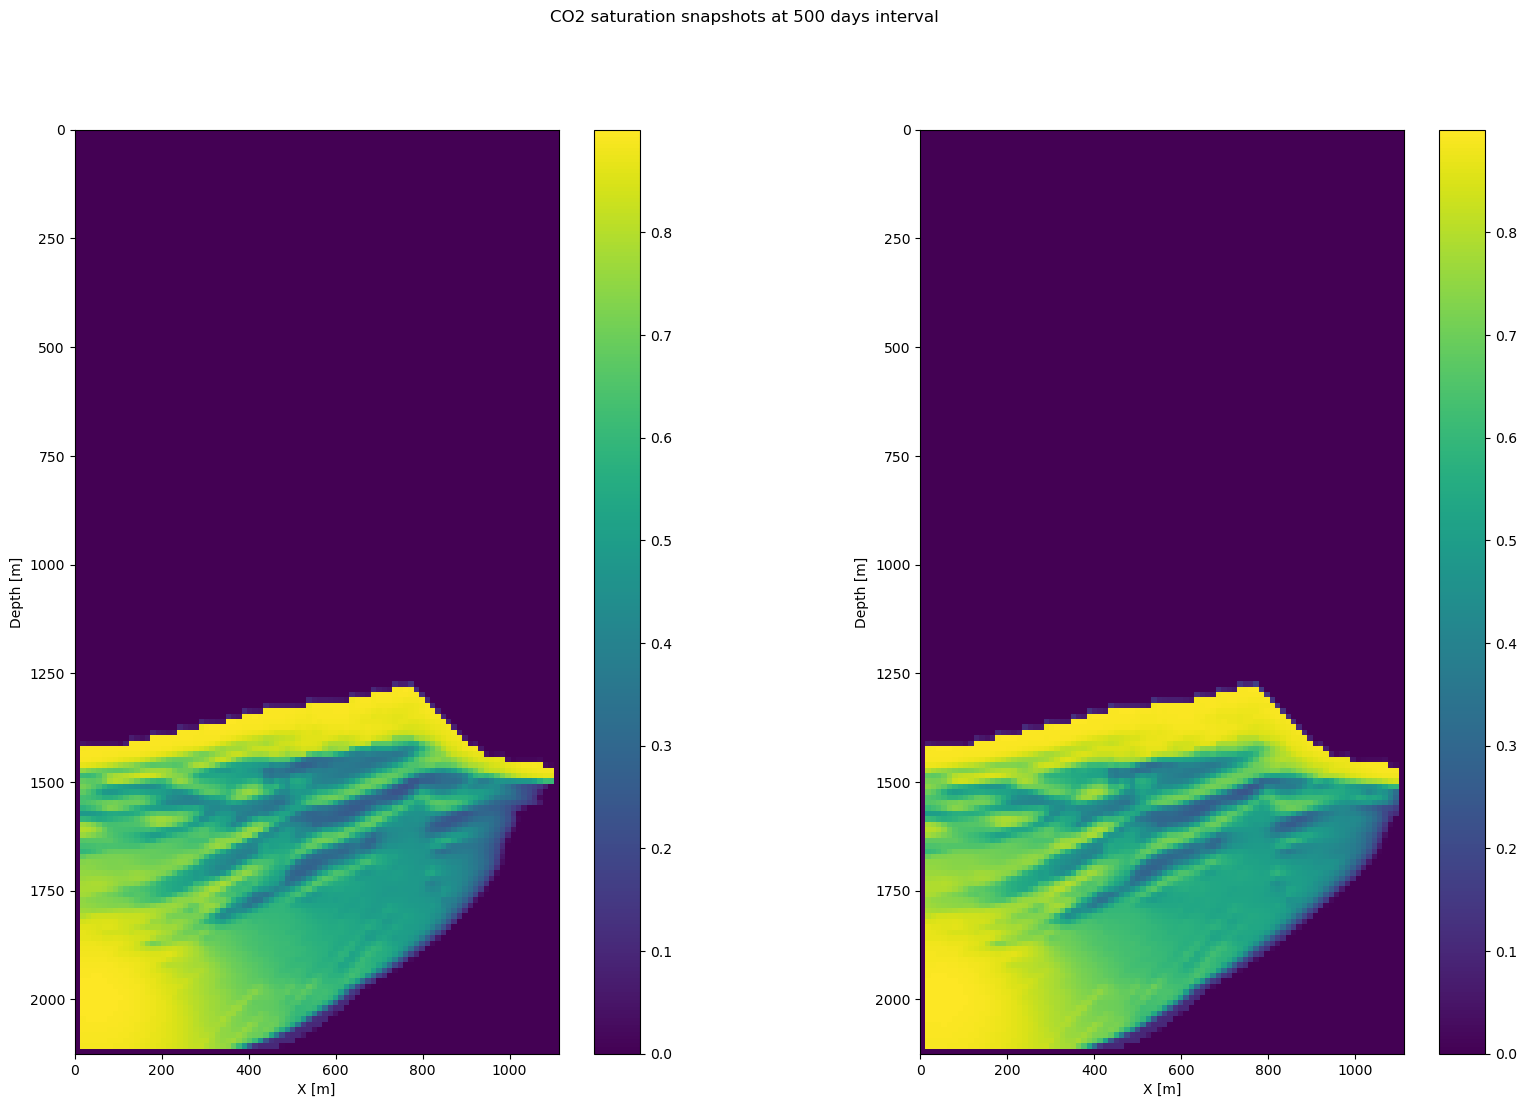

PyObject Text(0.5, 0.98, 'CO2 saturation snapshots at 500 days interval')

In [16]:
# Plot fourth-step saturation results
figure(figsize=(20,12));
for i = 1:2
    subplot(1,2,i)
    imshow(reshape(Saturations(state.states[i]), n[1], n[end])', extent=(0,(n[1]-1)*d[1],(n[3]-1)*d[3],0); vmin=0, vmax=maximum(Saturations(state.states[end])))
    xlabel("X [m]");ylabel("Depth [m]");
    colorbar()
end
suptitle("CO2 saturation snapshots at 500 days interval")

In [17]:
# Fifth Step
# Keep injection rate as high as possible but also consider the pressure criterion
irate = 50e-2
q5 = jutulForce(irate, [inj_loc])

stateend = state.states[end]
@time state = S(log.(Trans), q5; state0=stateend)
pressure = reshape(Pressure(state.states[end]), (n[1], n[end]))'
point_pressure = pressure[idx_ucfmt[20+150],20]
println("Did you satisfy pressure criteria: ", (point_pressure > 1.3e7 && (point_pressure < 1.5e7)))
println("Pressure below seal for a specific point: ", point_pressure)
@assert(point_pressure > 1.3e7 && (point_pressure < 1.5e7))

╭────────────────┬──────────┬──────────────┬──────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │ Time per │    Total │
│                │  2 steps │ 10 ministeps │       ms │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┼──────────┤
│ Newton         │     16.0 │          3.2 │ 351.7340 │   32 (0) │
│ Linearization  │     21.0 │          4.2 │ 267.9878 │   42 (0) │
│ Linear solver  │     52.0 │         10.4 │ 108.2259 │  104 (0) │
╰────────────────┴──────────┴──────────────┴──────────┴──────────╯
╭────────────────┬──────────┬────────────┬─────────╮
│ Timing type    │     Each │   Relative │   Total │
│                │       ms │ Percentage │       s │
├────────────────┼──────────┼────────────┼─────────┤
│ Properties     │  11.8528 │     3.37 % │  0.3793 │
│ Equations      │  37.8130 │    14.11 % │  1.5881 │
│ Assembly       │   7.5397 │     2.81 % │  0.3167 │
│ Linear solve   │ 220.3646 │    62.65 % │  7.0517 │
│ Preconditioner │  37.6910 │    10.72 %

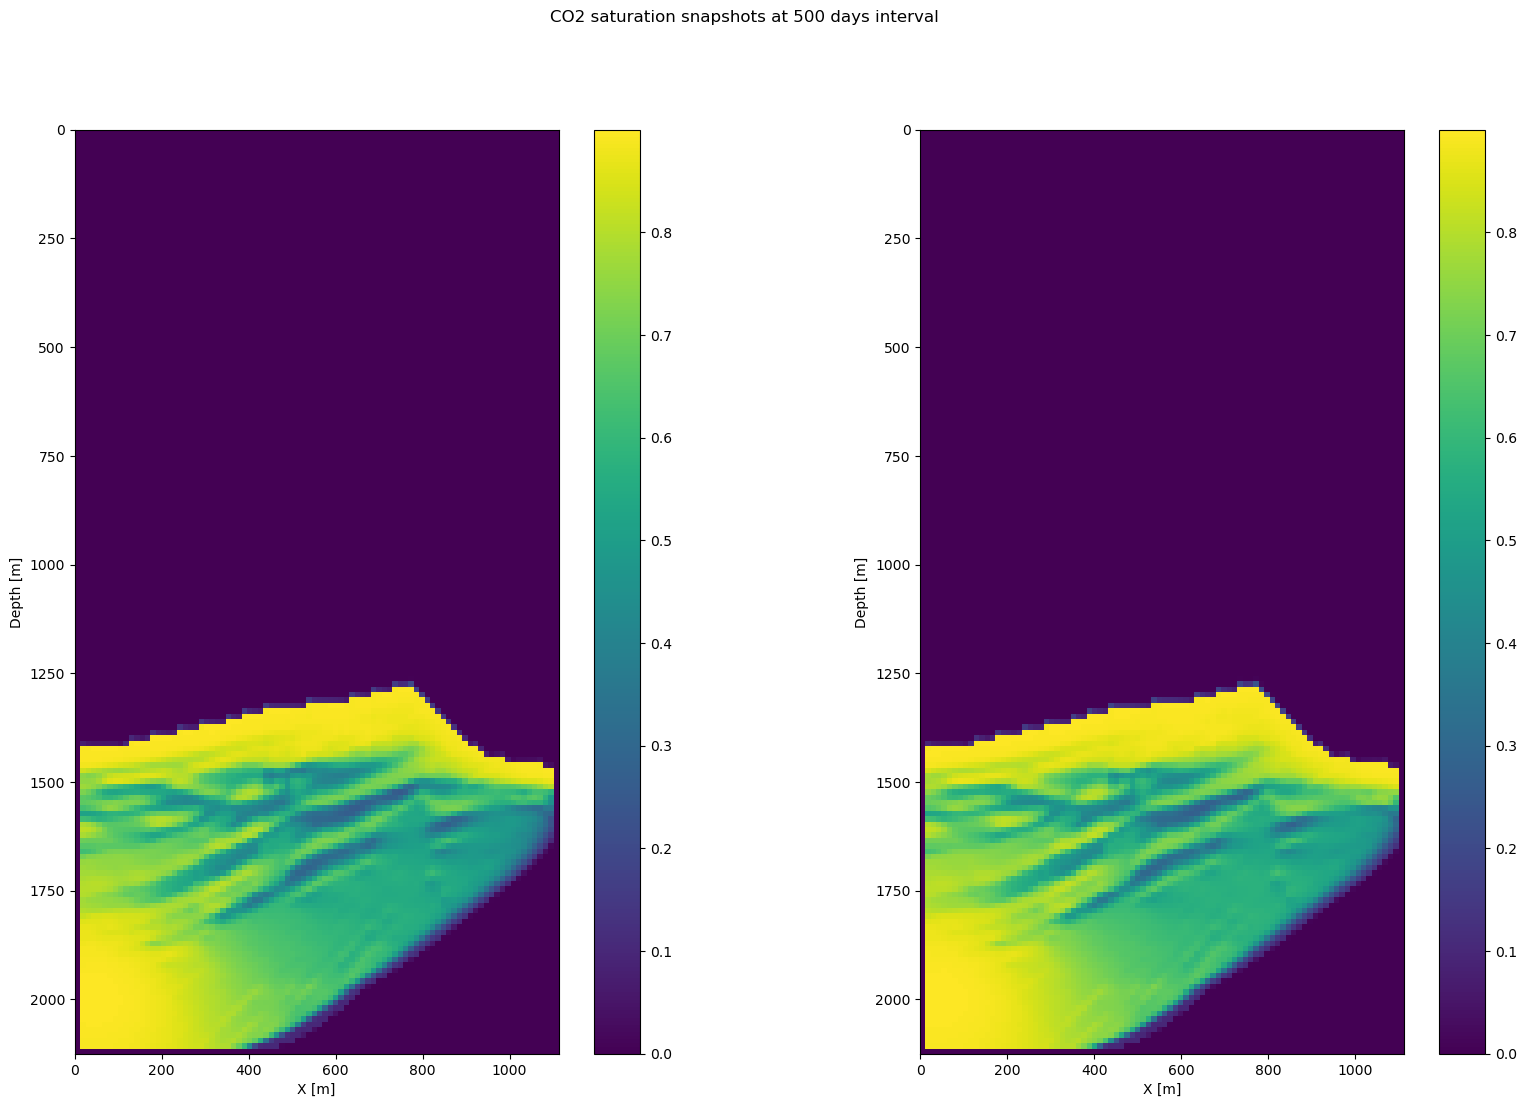

PyObject Text(0.5, 0.98, 'CO2 saturation snapshots at 500 days interval')

In [18]:
# Plot fifth-step saturation results
figure(figsize=(20,12));
for i = 1:2
    subplot(1,2,i)
    imshow(reshape(Saturations(state.states[i]), n[1], n[end])', extent=(0,(n[1]-1)*d[1],(n[3]-1)*d[3],0); vmin=0, vmax=maximum(Saturations(state.states[end])))
    xlabel("X [m]");ylabel("Depth [m]");
    colorbar()
end
suptitle("CO2 saturation snapshots at 500 days interval")

# Question

The goal of this homework is to maximize the volume of $CO_{2}$
injected. There are 5 simulation steps with corresponding plots of
saturation. Each step has an irate, which is the injection rate.  
In each step, the simulation will check the pressure, if it is between
13 MPa and 15 MPa and will output true. If it is not in this range it
will output false.  
The code will also output the pressure value.  
Start from the first step, check the simulation output to be true or
false, and then check the pressure value. If it is higher than 15 MPa,
decrease irate in the next simulation step or vice versa.  
Repeat and run all the steps and calculate the total injected volume
using the formula below.  
Remember, we need to maximize injectivity, so you may need to repeat the
whole experiment with different irate for each step and see what
combination of irate injects maximum CO2 to the reservoir without
exceeding fracture pressure of 15 MPa.

In [19]:
sum(Saturations(state.states[end]).*phi_m)*prod(model.d)

2.7496925569029254e8